The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.14.1


# Implementation of Recurrent Neural Networks from Scratch
:label:`sec_rnn_scratch`

In this section we implement a language model introduced in :numref:`chap_rnn` from scratch. It is based on a character-level recurrent neural network trained on H. G. Wells' *The Time Machine*. As before, we start by reading the dataset first, which is introduced in :numref:`sec_language_model`.


In [1]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## One-hot Encoding

Remember that each token is presented as a numerical index in `train_iter`.
Feeding these indices directly to the neural network might make it hard to
learn. We often present each token as a more expressive feature vector. The
easiest representation is called *one-hot encoding*.

In a nutshell, we map each index to a different unit vector: assume that the number of different tokens in the vocabulary is $N$ (the `len(vocab)`) and the token indices range from 0 to $N-1$. If the index of a token is the integer $i$, then we create a vector $\mathbf{e}_i$ of all 0s with a length of $N$ and set the element at position $i$ to 1. This vector is the one-hot vector of the original token. The one-hot vectors with indices 0 and 2 are shown below.


In [3]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

The shape of the minibatch we sample each time is (batch size, timestep). The `one_hot` function transforms such a minibatch into a 3-D tensor with the last dimension equals to the vocabulary size. We often transpose the input so that we will obtain a (timestep, batch size, vocabulary size) output that fits into a sequence model easier.


In [4]:
X = torch.arange(10).reshape(2, 5)
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

## Initializing the Model Parameters

Next, we initialize the model parameters for a RNN model. The number of hidden units `num_hiddens` is a tunable parameter.


In [5]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01
    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## RNN Model

First, we need an `init_rnn_state` function to return the hidden state at initialization. It returns a tensor filled with 0 and with a shape of (batch size, number of hidden units). Using tuples makes it easier to handle situations where the hidden state contains multiple variables (e.g., when combining multiple layers in an RNN where each layer requires initializing).


In [6]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

The following `rnn` function defines how to compute the hidden state and output
in a timestep. The activation function here uses the $\tanh$ function. As
described in :numref:`sec_mlp`, the
mean value of the $\tanh$ function is 0, when the elements are evenly
distributed over the real numbers.


In [7]:
def rnn(inputs, state, params):
    # Inputs shape: (num_steps, batch_size, vocab_size)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

Now we have all functions defined, next we create a class to wrap these functions and store parameters.


In [8]:
class RNNModelScratch: #@save
    """A RNN Model based on scratch implementations."""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward

    def __call__(self, X, state):
        X = F.one_hot(X.T.long(), self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

Let us do a sanity check whether inputs and outputs have the correct dimensions, e.g., to ensure that the dimensionality of the hidden state has not changed.


In [9]:
num_hiddens = 512
model = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                        init_rnn_state, rnn)
state = model.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = model(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

We can see that the output shape is (number steps $\times$ batch size, vocabulary size), while the hidden state shape remains the same, i.e., (batch size, number of hidden units).

## Prediction

We first explain the predicting function so we can regularly check the prediction during training. This function predicts the next `num_predicts` characters based on the `prefix` (a string containing several characters). For the beginning of the sequence, we only update the hidden state. After that we begin generating new characters and emitting them.


In [10]:
def predict_ch8(prefix, num_predicts, model, vocab, device):  #@save
    state = model.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(1, 1)
    for y in prefix[1:]:  # Warmup state with prefix
        _, state = model(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_predicts):  # Predict num_predicts steps
        Y, state = model(get_input(), state)
        outputs.append(int(Y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

We test the `predict_ch8` function first. Given that we did not train the network, it will generate nonsensical predictions. We initialize it with the sequence `traveller ` and have it generate 10 additional characters.


In [11]:
predict_ch8('time traveller ', 10, model, vocab, d2l.try_gpu())

'time traveller xceqprwlgw'

## Gradient Clipping

For a sequence of length $T$, we compute the gradients over these $T$ timesteps in an iteration, which results in a chain of matrix-products with length  $\mathcal{O}(T)$ during backpropagating. As mentioned in :numref:`sec_numerical_stability`, it might result in numerical instability, e.g., the gradients may either explode or vanish, when $T$ is large. Therefore, RNN models often need extra help to stabilize the training.

Recall that when solving an optimization problem, we take update steps for the weights $\mathbf{w}$ in the general direction of the negative gradient $\mathbf{g}_t$ on a minibatch, say $\mathbf{w} - \eta \cdot \mathbf{g}_t$. Let us further assume that the objective is well behaved, i.e., it is Lipschitz continuous with constant $L$, i.e.,

$$|l(\mathbf{w}) - l(\mathbf{w}')| \leq L \|\mathbf{w} - \mathbf{w}'\|.$$

In this case we can safely assume that if we update the weight vector by $\eta \cdot \mathbf{g}_t$, we will not observe a change by more than $L \eta \|\mathbf{g}_t\|$. This is both a curse and a blessing. A curse since it limits the speed of making progress, whereas a blessing since it limits the extent to which things can go wrong if we move in the wrong direction.

Sometimes the gradients can be quite large and the optimization algorithm may fail to converge. We could address this by reducing the learning rate $\eta$ or by some other higher order trick. But what if we only rarely get large gradients? In this case such an approach may appear entirely unwarranted. One alternative is to clip the gradients by projecting them back to a ball of a given radius, say $\theta$ via

$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$

By doing so we know that the gradient norm never exceeds $\theta$ and that the
updated gradient is entirely aligned with the original direction $\mathbf{g}$.
It also has the desirable side-effect of limiting the influence any given
minibatch (and within it any given sample) can exert on the weight vectors. This
bestows a certain degree of robustness to the model. Gradient clipping provides
a quick fix to the gradient exploding. While it does not entirely solve the problem, it is one of the many techniques to alleviate it.

Below we define a function to clip the gradients of a model that is either a building from scratch instance or a model constructed by the high-level APIs. Also note that we compute the gradient norm over all parameters.


In [12]:
def grad_clipping(model, theta):  #@save
    if isinstance(model, nn.Module):
        params = [p for p in model.parameters() if p.requires_grad]
    else:
        params = model.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## Training

Let us first define the function to train the model on one data epoch. It differs from the models training of :numref:`sec_softmax_scratch` in three places:

1. Different sampling methods for sequential data (random sampling and
   sequential partitioning) will result in differences in the initialization of
   hidden states.
1. We clip the gradients before updating the model parameters. This ensures that the model does not diverge even when gradients blow up at some point during the training process, and it effectively reduces the step size automatically.
1. We use perplexity to evaluate the model. This ensures that sequences of different length are comparable.


When the sequential partitioning is used, we initialize the hidden state at the beginning of each epoch. Since the $i^\mathrm{th}$ example in the next minibatch is adjacent to the current $i^\mathrm{th}$ example, so the next minibatch can use the current hidden state directly, we only detach the gradient so that we compute the gradients within a minibatch. When using the random sampling, we need to re-initialize the hidden state for each iteration since each example is sampled with a random position. Same as the `train_epoch_ch3` function in :numref:`sec_softmax_scratch`, we use generalized `updater`, which could be either a high-level API trainer or a scratched implementation.


In [13]:
def train_epoch_ch8(model, train_iter, loss, updater, device, use_random_iter):  #@save
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # loss_sum, num_examples
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize state when either it is the first iteration or
            # using random sampling.
            state = model.begin_state(batch_size=X.shape[0], device=device)
        else:
            for s in state:
                s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        py, state = model(X, state)
        l = loss(py, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(model, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(model, 1)
            updater(batch_size=1)  # Since used mean already
        metric.add(l * d2l.size(y), d2l.size(y))
    return math.exp(metric[0]/metric[1]), metric[1]/timer.stop()

The training function again supports either we implement the model from scratch or using high-level APIs.


In [14]:
#@save
def train_ch8(model, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    # Initialize
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[1, num_epochs])
    if isinstance(model, nn.Module):
        trainer = torch.optim.SGD(model.parameters(), lr)
        updater = lambda batch_size: trainer.step()
    else:
        updater = lambda batch_size: d2l.sgd(model.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, model, vocab, device)
    # Train and check the progress.
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            model, train_iter, loss, updater, device, use_random_iter)
        if epoch % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch+1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

Now we can train a model. Since we only use $10,000$ tokens in the dataset, the model needs more epochs to converge.


perplexity 1.2, 62669.4 tokens/sec on cuda:0
time traveller smiled round at us then still smiling faintly and
traveller  haw ste conthave at exasthr a surf whitwere the 


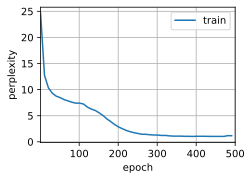

In [15]:
num_epochs, lr = 500, 1
train_ch8(model, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

Finally let us check the results to use a random sampling iterator.


perplexity 1.4, 63746.6 tokens/sec on cuda:0
time traveller smiled round at us then still smiling faintly and
traveller smiled round at us then still smiling faintly and


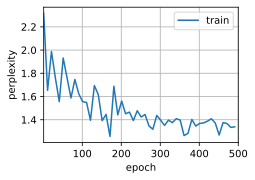

In [16]:
train_ch8(model, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

While implementing the above RNN model from scratch is instructive, it is not convenient. In the next section we will see how to improve significantly on the current model and how to make it faster and easier to implement.


## Summary

* Sequence models need state initialization for training.
* Between sequential models you need to ensure to detach the gradients, to ensure that the automatic differentiation does not propagate effects beyond the current sample.
* A simple RNN language model consists of an encoder, an RNN model, and a decoder.
* Gradient clipping prevents gradient explosion (but it cannot fix vanishing gradients).
* Perplexity calibrates model performance across different sequence length. It is the exponentiated average of the cross-entropy loss.
* Sequential partitioning typically leads to better models.

## Exercises

1. Show that one-hot encoding is equivalent to picking a different embedding for each object.
1. Adjust the hyperparameters to improve the perplexity.
    * How low can you go? Adjust embeddings, hidden units, learning rate, etc.
    * How well will it work on other books by H. G. Wells, e.g., [The War of the Worlds](http://www.gutenberg.org/ebooks/36).
1. Modify the predict function such as to use sampling rather than picking the most likely next character.
    * What happens?
    * Bias the model towards more likely outputs, e.g., by sampling from $q(w_t \mid w_{t-1}, \ldots, w_1) \propto p^\alpha(w_t \mid w_{t-1}, \ldots, w_1)$ for $\alpha > 1$.
1. Run the code in this section without clipping the gradient. What happens?
1. Change sequential partitioning so that it does not separate hidden states from the computational graph. Does the running time change? How about the accuracy?
1. Replace the activation function used in this section with ReLU and repeat the experiments in this section.
1. Prove that the perplexity is the inverse of the harmonic mean of the conditional word probabilities.


[Discussions](https://discuss.d2l.ai/t/486)
